In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.imputation import mice
from sklearn.utils import shuffle
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
from sklearn.preprocessing import RobustScaler

# 데이터 불러오기 (전처리 완료)

In [24]:
sample = pd.read_csv('sample_submission.csv')
train = pd.read_csv('data_p.csv')
test = pd.read_csv('test_p.csv')

## 모델링 첫 번째 (Feature Importance용)

In [25]:
# X_train should be your feature matrix (excluding the target variable), and y_train your target variable
X_train = train.drop('Target', axis=1)
y_train = train['Target']

# X_test should be your feature matrix for the test set
X_test = test

train_data = lgb.Dataset(X_train, label=y_train)

# Define LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'goss',
    'num_leaves': 28, # You can experiment with this value
    'learning_rate': 0.01,
    'feature_fraction': 0.33,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'min_data_in_leaf': 40,
    'scale_pos_weight': 33  # Adjust based on your positive rate (1 / positive_rate - 1)
}

# Train the model
num_round = 300
bst = lgb.train(params, train_data, num_round)

# Make predictions on the test set
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)



[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 176, number of negative: 5279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18361
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 73
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032264 -> initscore=-3.401008
[LightGBM] [Info] Start training from score -3.401008


In [26]:
# Assuming you have a binary classification problem, you can convert probabilities to binary predictions
y_pred = (y_pred > 0.5).astype(int)

sum(y_pred == 1)

70

## Feature Importance 시각화

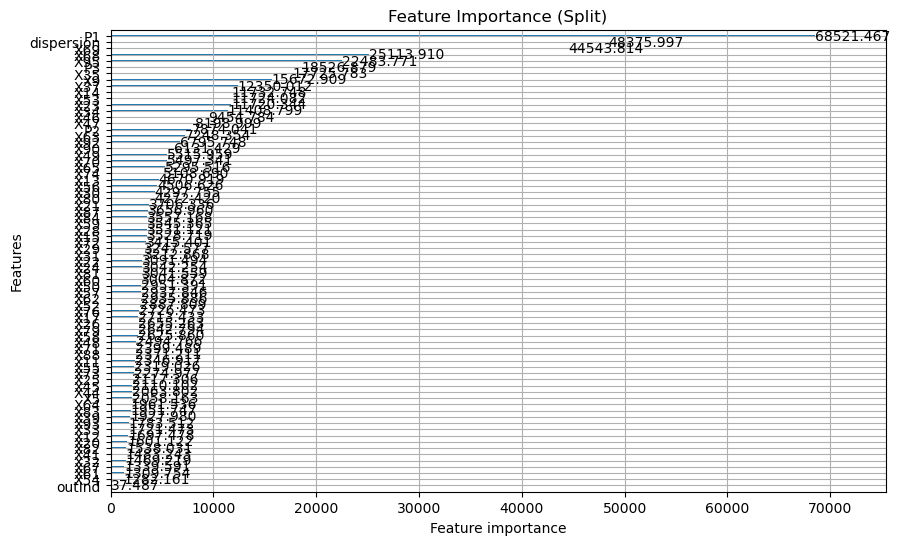

In [27]:
# 트리의 불순도 분리가 기준인 gain
lgb.plot_importance(bst, importance_type='gain', figsize=(10, 6), title='Feature Importance (Split)')
plt.show()

## 상위 11개 추출(gain 10,000 기준)

In [28]:
# Get feature importance
feature_importance = bst.feature_importance(importance_type='gain')

# Create a DataFrame with feature names and their importance
df_importance = pd.DataFrame({'Feature': bst.feature_name(), 'Importance': feature_importance})

# Sort the DataFrame by Importance in descending order
df_importance_sorted = df_importance.sort_values(by='Importance', ascending=False)

# Select the top 12 features
head_12_features = df_importance_sorted.head(11)
head_12_features

,Feature,Importance
69,P1,68521.466589
68,dispersion,48375.996550
49,X69,44543.813759
48,X68,25113.910481
67,X95,22483.770514
71,P3,18526.878632
22,X35,17725.783023
1,X9,15672.908889
23,X37,12350.011777
5,X14,11732.748001


In [29]:
r_index = ['P1','X68','X69','dispersion','X95','X9', 'X35', 'X14', 'X90', 'X37', 'X53', 'Target']
p_index = ['P1','X68','X69','dispersion','X95','X9', 'X35', 'X14', 'X90', 'X37', 'X53']

In [30]:
train = train[r_index]
test = test[p_index]

In [31]:
train.to_csv("data_p.csv", index=False)
test.to_csv("test_p.csv", index=False)